In [5]:
from bulid_transformer_model import bulid_model
from data_loading import load_data
from sequence_generator import seq_generator
from experiment_filter import filter
import tensorflow as tf
from tensorflow.keras.layers import Layer,Dense,Input
import tensorflow as tf
import numpy as np 
import Affine_transformation 
import importlib
#from new_affine_transformation import Af
from matplotlib import pyplot as plt
#importlib.reload(Affine_transformation)





In [6]:

experiments = filter('VISl',0.7)
(train_movie,train_trace,train_speed,eye_train),(val_movie,val_trace,val_speed,eye_val) = load_data(experiment_id=experiments[1],train_reliablity=0.4,test_reliablity=0)

(9000,) im here


In [26]:
import tensorflow as tf

def transformer(data,image_shape = (304,608,1),affine_shape =(6),grid_shape = (3,304*608) , name='SpatialTransformer2dAffine'):
    def _interpolate(im, x, y, out_size):
        # constants
        num_batch = tf.shape(input=im)[0]
        height = tf.shape(input=im)[1]
        width = tf.shape(input=im)[2]
        channels = tf.shape(input=im)[3]

        x = tf.cast(x, 'float32')
        y = tf.cast(y, 'float32')
        height_f = tf.cast(height, 'float32')
        width_f = tf.cast(width, 'float32')
        out_height = out_size[0]
        out_width = out_size[1]
        zero = tf.zeros([], dtype='int32')
        max_y = tf.cast(tf.shape(input=im)[1] - 1, 'int32')
        max_x = tf.cast(tf.shape(input=im)[2] - 1, 'int32')

        # scale indices from [-1, 1] to [0, width/height]
        x = (x + 1.0) * (width_f) / 2.0
        y = (y + 1.0) * (height_f) / 2.0

        # do sampling
        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)
        dim2 = width
        dim1 = width * height
        base = tf.repeat(tf.range(num_batch) * dim1,out_height * out_width,axis = 0)
        base_y0 = base + y0 * dim2
        base_y1 = base + y1 * dim2
        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        # use indices to lookup pixels in the flat image and restore
        # channels dim
        im_flat = tf.reshape(im, tf.stack([-1, channels]))
        im_flat = tf.cast(im_flat, 'float32')
        Ia = tf.gather(im_flat, idx_a)
        Ib = tf.gather(im_flat, idx_b)
        Ic = tf.gather(im_flat, idx_c)
        Id = tf.gather(im_flat, idx_d)

        # and finally calculate interpolated values
        x0_f = tf.cast(x0, 'float32')
        x1_f = tf.cast(x1, 'float32')
        y0_f = tf.cast(y0, 'float32')
        y1_f = tf.cast(y1, 'float32')
        wa = tf.expand_dims(((x1_f - x) * (y1_f - y)), 1)
        wb = tf.expand_dims(((x1_f - x) * (y - y0_f)), 1)
        wc = tf.expand_dims(((x - x0_f) * (y1_f - y)), 1)
        wd = tf.expand_dims(((x - x0_f) * (y - y0_f)), 1)
        output = tf.add_n([wa * Ia, wb * Ib, wc * Ic, wd * Id])
        return output
    
    out_size = image_shape[:-1]

    inputs = data[:,:tf.math.reduce_prod(image_shape)]
    inputs = tf.reshape(inputs,(-1,image_shape[0],image_shape[1],image_shape[2]))

    affines = data[:,tf.math.reduce_prod(image_shape):tf.math.reduce_prod(image_shape)+affine_shape]
    affines = tf.reshape(affines,shape = (-1,2,3))
    grid = data[:,tf.math.reduce_prod(image_shape)+affine_shape:]
    grid = tf.reshape(grid,(-1,grid_shape[0],grid_shape[1]))




   
    # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
    T_g = tf.matmul(affines, grid)
    x_s = tf.slice(T_g, [0, 0, 0], [-1, 1, -1])
    y_s = tf.slice(T_g, [0, 1, 0], [-1, 1, -1])
    x_s_flat = tf.reshape(x_s, [-1])
    y_s_flat = tf.reshape(y_s, [-1])

    input_transformed = _interpolate(inputs, x_s_flat, y_s_flat, out_size)

    output = tf.reshape(input_transformed, tf.stack([tf.shape(inputs)[0], image_shape[0], image_shape[1], image_shape[2]]))
    return output

class Af(tf.keras.layers.Layer): 
    def build(self,input_shape):
        img_shape = input_shape[0]
        affine_shape = input_shape[1]
        self.img_shape = img_shape
        self.affine_shape = affine_shape
        x_t = tf.linspace(-1,1,img_shape[3])
        y_t = tf.linspace(-1,1,img_shape[2])
        x_t,y_t = tf.meshgrid(x_t,y_t)
        x_t = tf.reshape(x_t,(-1))
        y_t = tf.reshape(y_t,(-1))
        x_t = tf.cast(x_t,dtype= tf.float32)
        y_t = tf.cast(y_t,dtype= tf.float32)
        ones = tf.ones(tf.shape(x_t)[0])
        grid = tf.stack([x_t,y_t,ones],axis = 0)
        grid  = tf.expand_dims(grid,0)
        grid = tf.repeat(grid,img_shape[1],axis = 0 )
        self.grid = grid
    def call(self,input):
        stimuli_input =input[0]
        eye_input = input[1]
        shape_stimuli = tf.shape(stimuli_input)
        #shape_eye = self.affine_shape#tf.shape(eye_input)        
        b = shape_stimuli[0]
        f = shape_stimuli[1]
        stimuli_input = tf.cast(stimuli_input,dtype=tf.float32)
        stimuli_input = tf.reshape(stimuli_input,shape=(b,f,-1))
        eye_input = tf.reshape(eye_input,shape = (b,f,-1))
        eye_input = tf.cast(eye_input,dtype = tf.float32)
        grid  = tf.expand_dims(self.grid,0)
        grid = tf.repeat(grid,b,axis = 0 )
        grid = tf.reshape(grid,(b,f,-1))
        input_data = tf.concat([stimuli_input,eye_input,grid],axis = -1 )
        out = tf.map_fn(transformer,input_data)
        out = tf.reshape(out,shape_stimuli)
        return out 
        

In [7]:
t = seq_generator(train_movie,train_trace,train_speed,eye_train,delay =10)
p = next(t)[0][0]
a = np.array([0.7,-0.7,0,
              0.7,0.7,0])
a = np.expand_dims(a,0)
a = np.expand_dims(a,0)
a = np.repeat(a,3,0)
a = np.repeat(a,10,1).astype('float32')
#a = a.reshape((10,2,3)).astype('float32')
#y = Affine_transformation.Affine_transform()(p,a)




In [13]:
class transformer():
    def __init__(self,batch_size = 3,image_shape = (304,608,1),out_size = (304,608),grid_shape = (3,304*608) , name='SpatialTransformer2dAffine') -> None:
        self.image_shape = image_shape
        self.height = image_shape[0]
        self.width = image_shape[1]
        self.channels = image_shape[2]
        self.affine_shape = 6
        self.grid_shape = grid_shape
        self.batch =batch_size
        self.out_size = out_size
    def interpolate(self,im,x,y):
        # constants
        num_batch = self.batch
        height = self.height
        width = self.width
        channels = self.channels
        out_size = self.out_size

        x = tf.cast(x, 'float32')
        y = tf.cast(y, 'float32')
        height_f = tf.cast(height, 'float32')
        width_f = tf.cast(width, 'float32')
        out_height = out_size[0]
        out_width = out_size[1]
        zero = tf.zeros([], dtype='int32')
        max_y = tf.cast(height - 1, 'int32')
        max_x = tf.cast(width - 1, 'int32')

        # scale indices from [-1, 1] to [0, width/height]
        x = (x + 1.0) * (width_f) / 2.0
        y = (y + 1.0) * (height_f) / 2.0

        # do sampling
        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)
        dim2 = width
        dim1 = width * height
        base = tf.repeat(tf.range(num_batch) * dim1,out_height * out_width,axis = 0)
        base_y0 = base + y0 * dim2
        base_y1 = base + y1 * dim2
        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        # use indices to lookup pixels in the flat image and restore
        # channels dim
        im_flat = tf.reshape(im, tf.stack([height*width*num_batch, channels]))
        im_flat = tf.cast(im_flat, 'float32')
        Ia = tf.gather(im_flat, idx_a)
        Ib = tf.gather(im_flat, idx_b)
        Ic = tf.gather(im_flat, idx_c)
        Id = tf.gather(im_flat, idx_d)

        # and finally calculate interpolated values
        x0_f = tf.cast(x0, 'float32')
        x1_f = tf.cast(x1, 'float32')
        y0_f = tf.cast(y0, 'float32')
        y1_f = tf.cast(y1, 'float32')
        wa = tf.expand_dims(((x1_f - x) * (y1_f - y)), 1)
        wb = tf.expand_dims(((x1_f - x) * (y - y0_f)), 1)
        wc = tf.expand_dims(((x - x0_f) * (y1_f - y)), 1)
        wd = tf.expand_dims(((x - x0_f) * (y - y0_f)), 1)
        output = tf.add_n([wa * Ia, wb * Ib, wc * Ic, wd * Id])
        return output
    def __call__(self, data):

        inputs = data[:,:tf.math.reduce_prod(self.image_shape)]
        inputs = tf.reshape(inputs,(self.batch,self.image_shape[0],self.image_shape[1],self.image_shape[2]))

        affines = data[:,tf.math.reduce_prod(self.image_shape):tf.math.reduce_prod(self.image_shape)+self.affine_shape]
        affines = tf.reshape(affines,shape = (self.batch,2,3))
        grid = data[:,tf.math.reduce_prod(self.image_shape)+self.affine_shape:]
        grid = tf.reshape(grid,(self.batch,self.grid_shape[0],self.grid_shape[1]))




    
        # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
        T_g = tf.matmul(affines, grid)
        x_s = tf.slice(T_g, [0, 0, 0], [self.batch, 1, self.grid_shape[1]])
        y_s = tf.slice(T_g, [0, 1, 0], [self.batch, 1, self.grid_shape[1]])
        x_s_flat = tf.reshape(x_s, [self.batch*self.grid_shape[1]])
        y_s_flat = tf.reshape(y_s, [self.batch*self.grid_shape[1]])

        input_transformed = self.interpolate(inputs, x_s_flat, y_s_flat)

        output = tf.reshape(input_transformed, tf.stack([self.batch, self.image_shape[0], self.image_shape[1], self.image_shape[2]]))
        return output
class Af(tf.keras.layers.Layer): 
    def build(self,input_shape):
        img_shape = input_shape[0]
        affine_shape = input_shape[1]
        self.img_shape = img_shape
        self.affine_shape = affine_shape
        x_t = tf.linspace(-1,1,img_shape[3])
        y_t = tf.linspace(-1,1,img_shape[2])
        x_t,y_t = tf.meshgrid(x_t,y_t)
        x_t = tf.reshape(x_t,(-1))
        y_t = tf.reshape(y_t,(-1))
        x_t = tf.cast(x_t,dtype= tf.float32)
        y_t = tf.cast(y_t,dtype= tf.float32)
        ones = tf.ones(tf.shape(x_t)[0])
        grid = tf.stack([x_t,y_t,ones],axis = 0)
        grid  = tf.expand_dims(grid,0)
        grid = tf.repeat(grid,img_shape[1],axis = 0 )
        self.t = transformer(img_shape[1],img_shape[2:],
                             img_shape[2:-1],
                             (3,img_shape[2]*img_shape[3]))
        self.grid = grid
    def call(self,input):
        stimuli_input =input[0]
        eye_input = input[1]
        shape_stimuli = tf.shape(stimuli_input)
        #shape_eye = self.affine_shape#tf.shape(eye_input)        
        b = shape_stimuli[0]
        f = shape_stimuli[1]
        stimuli_input = tf.cast(stimuli_input,dtype=tf.float32)
        stimuli_input = tf.reshape(stimuli_input,shape=(b,f,-1))
        eye_input = tf.reshape(eye_input,shape = (b,f,-1))
        eye_input = tf.cast(eye_input,dtype = tf.float32)
        grid  = tf.expand_dims(self.grid,0)
        grid = tf.repeat(grid,b,axis = 0 )
        grid = tf.reshape(grid,(b,f,-1))
    
        input_data = tf.concat([stimuli_input,eye_input,grid],axis = -1 )
        out = tf.vectorized_map(self.t.__call__,input_data)
        out = tf.reshape(out,shape_stimuli)
        return out 



In [14]:
y = Af()([p,a])

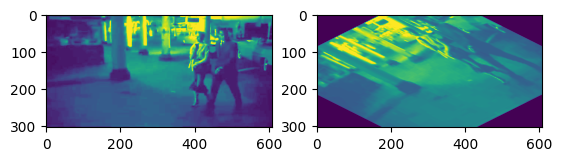

In [15]:
plt.subplot(1,2,1)
plt.imshow(p[0,0])
plt.subplot(1,2,2)
plt.imshow(y[0,0])
